In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

## data source
## https://grouplens.org/datasets/movielens/100k/

In [187]:
%cd project/ml-100k
%ls

[Errno 2] No such file or directory: 'project/ml-100k'
/Users/ruihua/Desktop/UdemyMachineLearning-master/Module 3/project/ml-100k
DATA/         u.data        u.user        u3.base       u5.test
README        u.genre       u1.base       u3.test       ua.base
allbut.pl*    u.info        u1.test       u4.base       ua.test
img/          u.item        u2.base       u4.test       ub.base
mku.sh*       u.occupation  u2.test       u5.base       ub.test


In [174]:
!head u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [7]:
names = ['user_id','item_id','rating','timestamp']

In [8]:
df = pd.read_csv('u.data',sep='\t',names=names)

In [9]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


In [11]:
#create a rating matrix
ratings = np.zeros([n_users, n_items])

In [12]:
for r in df.itertuples():
    ratings[r[1]-1,r[2]-1] = r[3]
ratings[:10, :10]

array([[5., 3., 4., 3., 3., 5., 4., 1., 5., 3.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 2., 4., 4., 0.],
       [0., 0., 0., 5., 0., 0., 5., 5., 5., 4.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 0., 0., 0.],
       [4., 0., 0., 4., 0., 0., 4., 0., 4., 0.]])

In [73]:
ratings.nonzero() # index of nonzero elements

(array([  0,   0,   0, ..., 942, 942, 942]),
 array([   0,    1,    2, ..., 1187, 1227, 1329]))

Text(0,0.5,'Rating_number')

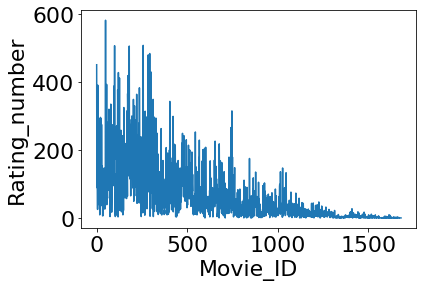

In [109]:
plt.plot(range(n_items),(ratings>0).sum(axis=0)) 
# number of raings for each movie
plt.xlabel("Movie_ID")
plt.ylabel("Rating_number")

Text(0,0.5,'average_Rating')

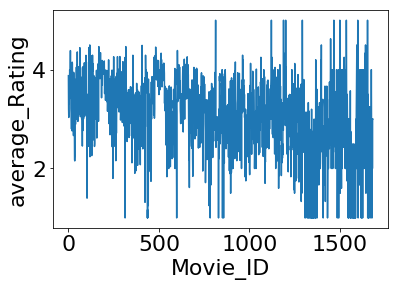

In [112]:
plt.plot(range(n_items), ratings.sum(axis = 0)/(ratings>0).sum(axis=0)) # A bar chart
plt.xlabel("Movie_ID")
plt.ylabel("average_Rating")

In [15]:
ratings[10:, 10:]

array([[2., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 5., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 5., 0., ..., 0., 0., 0.]])

In [16]:
def train_test_generation(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    #for each user
    for user in xrange(ratings.shape[0]):
        # pick 10 ratings randomly from each user
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        # set the ratings in training to be zero
        train[user, test_ratings] = 0.
        # set the ratings in the test to be the real value
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [17]:
train, test = train_test_generation(ratings)
train = np.ma.masked_where(train == 0, train) # ignore zeros in computation
test = np.ma.masked_where(test == 0, test)

In [18]:
len(train.nonzero()[0])

90570

In [19]:
len(test.nonzero()[0])

9430

In [20]:
len(ratings.nonzero()[0])

100000

In [21]:
# using MAE for evaluation
# mean absolute error
from sklearn.metrics import mean_absolute_error

# pred and actual are matrices of N by p
# actual can be test or training, depending on whether you are trying to 
# compute the test error or training error
def get_mae(pred, actual):
    # only compute on non-zero terms
    pred = pred[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

In [216]:
def myPlot(pred, actual,title):
    # pred here is the whole matrix, but we need to use the actual data to find the test part
    # actual is the test set, which is also a matrix
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    plt.plot(actual, pred, 'ro')
    plt.xlabel("actual")
    plt.ylabel("prediction")
    plt.xlim([0,6])
    plt.title(title)
    plt.show()

In [205]:
# baseline model, use user's rating average for prediction
user_bias = train.mean(axis=1) 
# the average rating from each user, what the the possible worse value you can get here?

print user_bias[:5]

prediction_baseline = np.zeros(test.shape) + user_bias[:,np.newaxis] 
print 'Baseline model MAE: ' + str(get_mae(prediction_baseline, test))
# the mean error for predicted ratings

[3.6030534351145036 3.673076923076923 2.8636363636363638 4.571428571428571
 2.8727272727272726]
Baseline model MAE: 0.8440545766994151


## to predict current user's rating to current movie 
## we find similar users as the current user based on their previous rating performance 
## use the rating from similar users to predict the current user's rating on a movie he has not rated

![title](cosinsimilar.png)

In [206]:
# first part, user-based and item-based collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity

# similarity matrix is always symmetric
# symmetric along diagonal, here we only still fill in zeros, 
# since the cosine_similarity can't recognize the masked value.
# if we really want to make it work, need to implement a special similarity function 
def similarity(ratings, kind='user'):
    if kind == 'user':
        sim = cosine_similarity(ratings) 
        #cosine_similarity, treat one row as one data point
        # sim is a N by N matrix
        assert(sim.shape[0] == ratings.shape[0])
    elif kind == 'item':
        sim = cosine_similarity(ratings.T)
        # sim is a p by p matrix
        assert(sim.shape[0] == ratings.shape[1])
    sim[np.isnan(sim)] = 0 # when could nan happen? think about it 
    np.fill_diagonal(sim,0) # when compute neighbors, we don't need to compute itself
    return sim

In [207]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')
print user_similarity[:4, :4]
print item_similarity[:4, :4]

[[0.         0.14704878 0.0404896  0.0656254 ]
 [0.14704878 0.         0.11587296 0.19447318]
 [0.0404896  0.11587296 0.         0.25362461]
 [0.0656254  0.19447318 0.25362461 0.        ]]
[[0.         0.39991678 0.31821772 0.44342412]
 [0.39991678 0.         0.29209442 0.49576936]
 [0.31821772 0.29209442 0.         0.30230919]
 [0.44342412 0.49576936 0.30230919 0.        ]]


In [208]:
print user_similarity.max()
print user_similarity.mean()
print user_similarity.min()

print item_similarity.max()
print item_similarity.mean()
print item_similarity.min()

# consine similarity always report positive value or 0

0.7911266900280762
0.14327250070158856
0.0
1.0
0.08556359368305448
0.0


In [209]:
np.nonzero(np.ma.getmask(train.mean(axis=0))) # we have some items without any ratings

(array([1234, 1309, 1328, 1612, 1652, 1653, 1662, 1679]),)

In [210]:
user_similarity.shape

(943, 943)

![title](userbasedCF.png)

In [211]:
# prediction function
# use all ratings, including zero
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        # in case there is a whole column or row with zero, 
        # i.e. this user/item is not similar to any others, add a small number 
        
        # similarity is a matrix of N by N, row i is the similarity of user i to all other people
        # ratings is a matrix of N by p (centralized already), column k is the ratings from all the people for item k 
        # for one row of similarity dot product with one column of rating,
        # we compute the sum of the weighted ratings for all neighbors for user i, "sum(sim(k,n)*r_ni)"
        # this value, divided by the sum of all the similarities for user i, and added back the user_bias
        # will be the pred(i, k)
        
        pred = np.ma.dot(similarity, ratings) / np.array([np.abs(similarity).sum(axis=1)+1e-6]).T
        pred += user_bias[:, np.newaxis]
        
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = np.ma.dot(ratings, similarity) / np.array([np.abs(similarity).sum(axis=1)+1e-6])
        pred += item_bias[np.newaxis, :]
    
    return pred


User-based CF train MAE: 0.7918403531770507
Item-based CF train MAE: 0.7668755851644709
User-based CF test MAE: 0.815264044486309
Item-based CF test MAE: 0.82640924376463


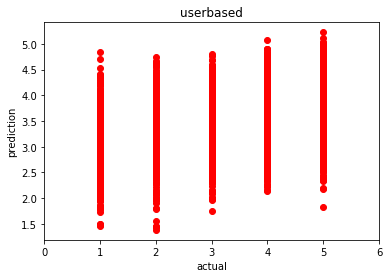

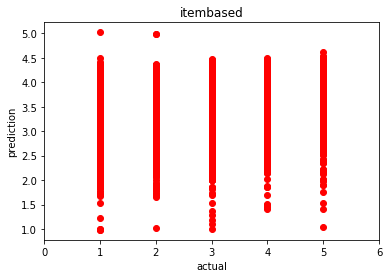

In [217]:
user_prediction = predict(train, user_similarity, kind='user')
item_prediction = predict(train, item_similarity, kind='item')

print 'User-based CF train MAE: ' + str(get_mae(user_prediction, train))
print 'Item-based CF train MAE: ' + str(get_mae(item_prediction, train))
print 'User-based CF test MAE: ' + str(get_mae(user_prediction, test))
print 'Item-based CF test MAE: ' + str(get_mae(item_prediction, test))
myPlot(user_prediction, test, 'userbased')
myPlot(item_prediction, test, 'itembased')

In [31]:
user_sim_nearest_neighbor = user_similarity.copy()
user_sim_nearest_neighbor[user_sim_nearest_neighbor<0.30]=0

item_sim_nearest_neighbor = item_similarity.copy()
item_sim_nearest_neighbor[item_sim_nearest_neighbor<0.30]=0


User-based CF train MAE: 0.7720905648013537
Item-based CF train MAE: 0.7354196669023171
User-based CF test MAE: 0.806253443122098
Item-based CF test MAE: 0.8078639555962539


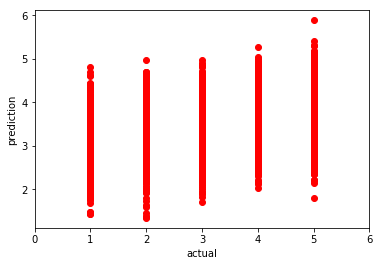

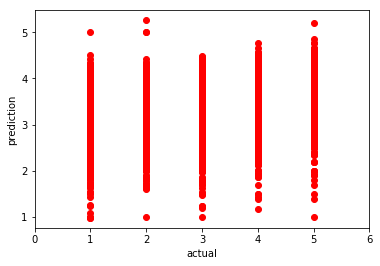

In [32]:
user_prediction = predict(train, user_sim_nearest_neighbor, kind='user')
item_prediction = predict(train, item_sim_nearest_neighbor, kind='item')

print 'User-based CF train MAE: ' + str(get_mae(user_prediction, train))
print 'Item-based CF train MAE: ' + str(get_mae(item_prediction, train))
print 'User-based CF test MAE: ' + str(get_mae(user_prediction, test))
print 'Item-based CF test MAE: ' + str(get_mae(item_prediction, test))
myPlot(user_prediction, test)
myPlot(item_prediction, test)

Matrix Factorization CF training MAE: 0.6613324029129294
Matrix Factorization CF test MAE: 0.7999074811998661


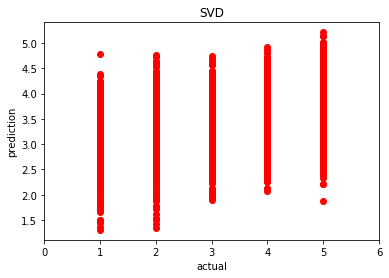

In [230]:
# **********************************************************************************************

# assume unseen ratings are all zero
# try using user mean, will it be better?

from scipy.sparse.linalg import svds # svd solver

user_ratings_mean = np.mean(train, axis = 1)
R_demeaned = train - user_ratings_mean.reshape(-1, 1)
U, sigma, Vt = svds(R_demeaned, k=20) #solve for svd, sigma is returned a vector
sigma = np.diag(sigma) # create a diagonal matrix
# dignonal matrix example
# 2 0 0
# 0 1 0 
# 0 0 0.5

# np.dot(np.dot(U, sigma), Vt) is a low rank estimation to the R_demeaned
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
print 'Matrix Factorization CF training MAE: ' + str(get_mae(all_user_predicted_ratings, train))
print 'Matrix Factorization CF test MAE: ' + str(get_mae(all_user_predicted_ratings, test))
myPlot(all_user_predicted_ratings, test, 'SVD')

In [229]:
def mySVD(train, test, k):
    user_ratings_mean = np.mean(train, axis = 1)
    R_demeaned = train - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return get_mae(all_user_predicted_ratings, train), get_mae(all_user_predicted_ratings, test)

In [255]:
ks = [1,2,5,8,10,15,20,30,50,100]
train_MAEs = []
test_MAEs = []
for k in ks:
    train_MAE, test_MAE = mySVD(train, test, k)
    train_MAEs.append(train_MAE)
    test_MAEs.append(test_MAE)


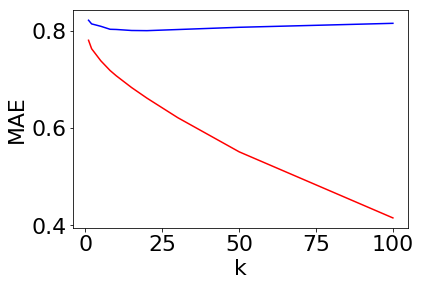

In [262]:
plt.plot(ks, train_MAEs, 'r', label = 'training error')
plt.plot(ks, test_MAEs, 'b',label = 'training error')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()


![title](SGD.png)

In [ ]:
# directly optimize the objective function, on the seen ratings
# ideally we should wait till the algorithm find a local minimum, but stop earlier sometimes
# will provide better prediction power

import numpy

#beta regularization
#alpha learning rate

def matrix_factorization(train, K, steps=10, alpha=0.0001, beta=0.02):
    N_user, N_item = train.shape
    # U and V are latent vectors
    U = numpy.random.rand(N_user,K)
    V = numpy.random.rand(N_item,K).T
    
    for step in xrange(steps):
        for i in xrange(N_user):
            for j in xrange(N_item):
                if train[i,j] > 0:
                    eij = numpy.dot(U[i,:],V[:,j]) - train[i][j]  
                    U[i] = U[i] - alpha * (2 * eij * V[:,j] + beta * U[i])
                    V[:,j] = V[:,j] - alpha * (2 * eij * U[i] + beta * V[:,j])
    
    nR = numpy.dot(U, V)
    return nR

In [52]:
K = 10

prediction_sgd = matrix_factorization(train, K=10, steps=10, alpha=0.001)


In [248]:
print 'Matrix Factorization SGD CF MAE training: ' + str(get_mae(prediction_sgd, train))
print 'Matrix Factorization SGD CF MAE test: ' + str(get_mae(prediction_sgd, test))

Matrix Factorization SGD CF MAE training: 0.7297593229720716
Matrix Factorization SGD CF MAE test: 0.7992031492256381


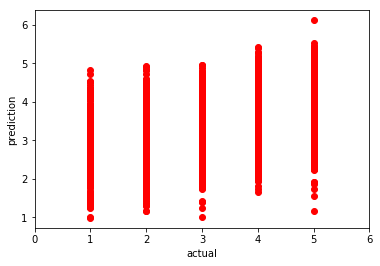

In [54]:
myPlot(prediction_sgd, test)

Text(0.5,1,'prediction by different models')

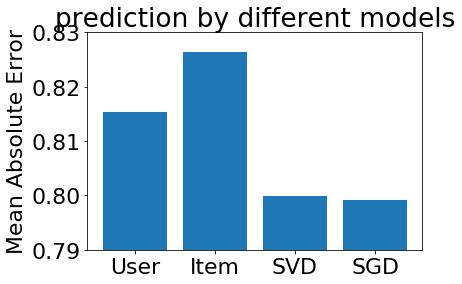

In [246]:
names = ['User','Item','SVD','SGD']
CFmae = [get_mae(user_prediction,test),get_mae(item_prediction,test),get_mae(all_user_predicted_ratings, test),get_mae(prediction_sgd, test)]
plt.bar(names,CFmae)
plt.ylabel('Mean Absolute Error')
plt.ylim(0.79, 0.83)
plt.title('prediction by different models')
